In [17]:
#Load packages and set options
library(tidyverse)
library(tidymodels)
library(janitor)
library(repr)

options(repr.matrix.max.rows = 6)
options(repr.plot.width = 12, repr.plot.height = 12)

In [18]:
#Reading data set from the web
url <- "https://raw.githubusercontent.com/trungnguyen21/group_project_dsci/main/data/rice_data.csv"
rice_data <- read_csv(url)
rice_data

New names:
• `` -> `...1`
Rows: 3810 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Class
dbl (8): ...1, Area, Perimeter, Major_Axis_Length, Minor_Axis_Length, Eccent...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,15231,525.579,229.7499,85.09379,0.9288820,15617,0.5728955,b'Cammeo'
1,14656,494.311,206.0201,91.73097,0.8954050,15072,0.6154363,b'Cammeo'
2,14634,501.122,214.1068,87.76829,0.9121181,14954,0.6932588,b'Cammeo'
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
3807,12437,442.499,183.5729,86.80198,0.8811443,12645,0.6267385,b'Osmancik'
3808,9882,392.297,161.1940,78.21048,0.8744061,10097,0.6590636,b'Osmancik'
3809,11434,404.710,161.0793,90.86819,0.8256922,11591,0.8029494,b'Osmancik'


In [19]:
#Cleaning data set: cleaning names, renaming class and changing to factor, and removing first column
rice <- rice_data |>
  clean_names() |>
  mutate(class = as_factor(class),
         class = fct_recode(class, "Cammeo" = "b'Cammeo'", "Osmancik" = "b'Osmancik'")) |>
  select(-x1)
rice

area,perimeter,major_axis_length,minor_axis_length,eccentricity,convex_area,extent,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
15231,525.579,229.7499,85.09379,0.9288820,15617,0.5728955,Cammeo
14656,494.311,206.0201,91.73097,0.8954050,15072,0.6154363,Cammeo
14634,501.122,214.1068,87.76829,0.9121181,14954,0.6932588,Cammeo
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
12437,442.499,183.5729,86.80198,0.8811443,12645,0.6267385,Osmancik
9882,392.297,161.1940,78.21048,0.8744061,10097,0.6590636,Osmancik
11434,404.710,161.0793,90.86819,0.8256922,11591,0.8029494,Osmancik


In [20]:
#Splitting data set into training and testing data sets
rice_split <- initial_split(rice, prop = 0.75, strata = class)
rice_train <- training(rice_split)
rice_test <- testing(rice_split)

In [21]:
#Summary table: means of each predictor, missing data count, and number of observations
rice_train_summary <- rice_train |>
  mutate(na_count = rowSums(is.na(rice_train))) |>
  group_by(class) |>
  summarize(across(area:na_count, mean), obs = n())
rice_train_summary

class,area,perimeter,major_axis_length,minor_axis_length,eccentricity,convex_area,extent,na_count,obs
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Cammeo,14159.49,487.3692,205.4422,88.76188,0.9010281,14491.18,0.6527959,0,1222
Osmancik,11549.13,429.3848,176.2236,84.49608,0.8761248,11799.80,0.6701478,0,1635


class,predictor,value
<fct>,<chr>,<dbl>
Cammeo,area,15231.0000
Cammeo,perimeter,525.5790
Cammeo,major_axis_length,229.7499
⋮,⋮,⋮
Osmancik,eccentricity,8.256922e-01
Osmancik,convex_area,1.159100e+04
Osmancik,extent,8.029494e-01


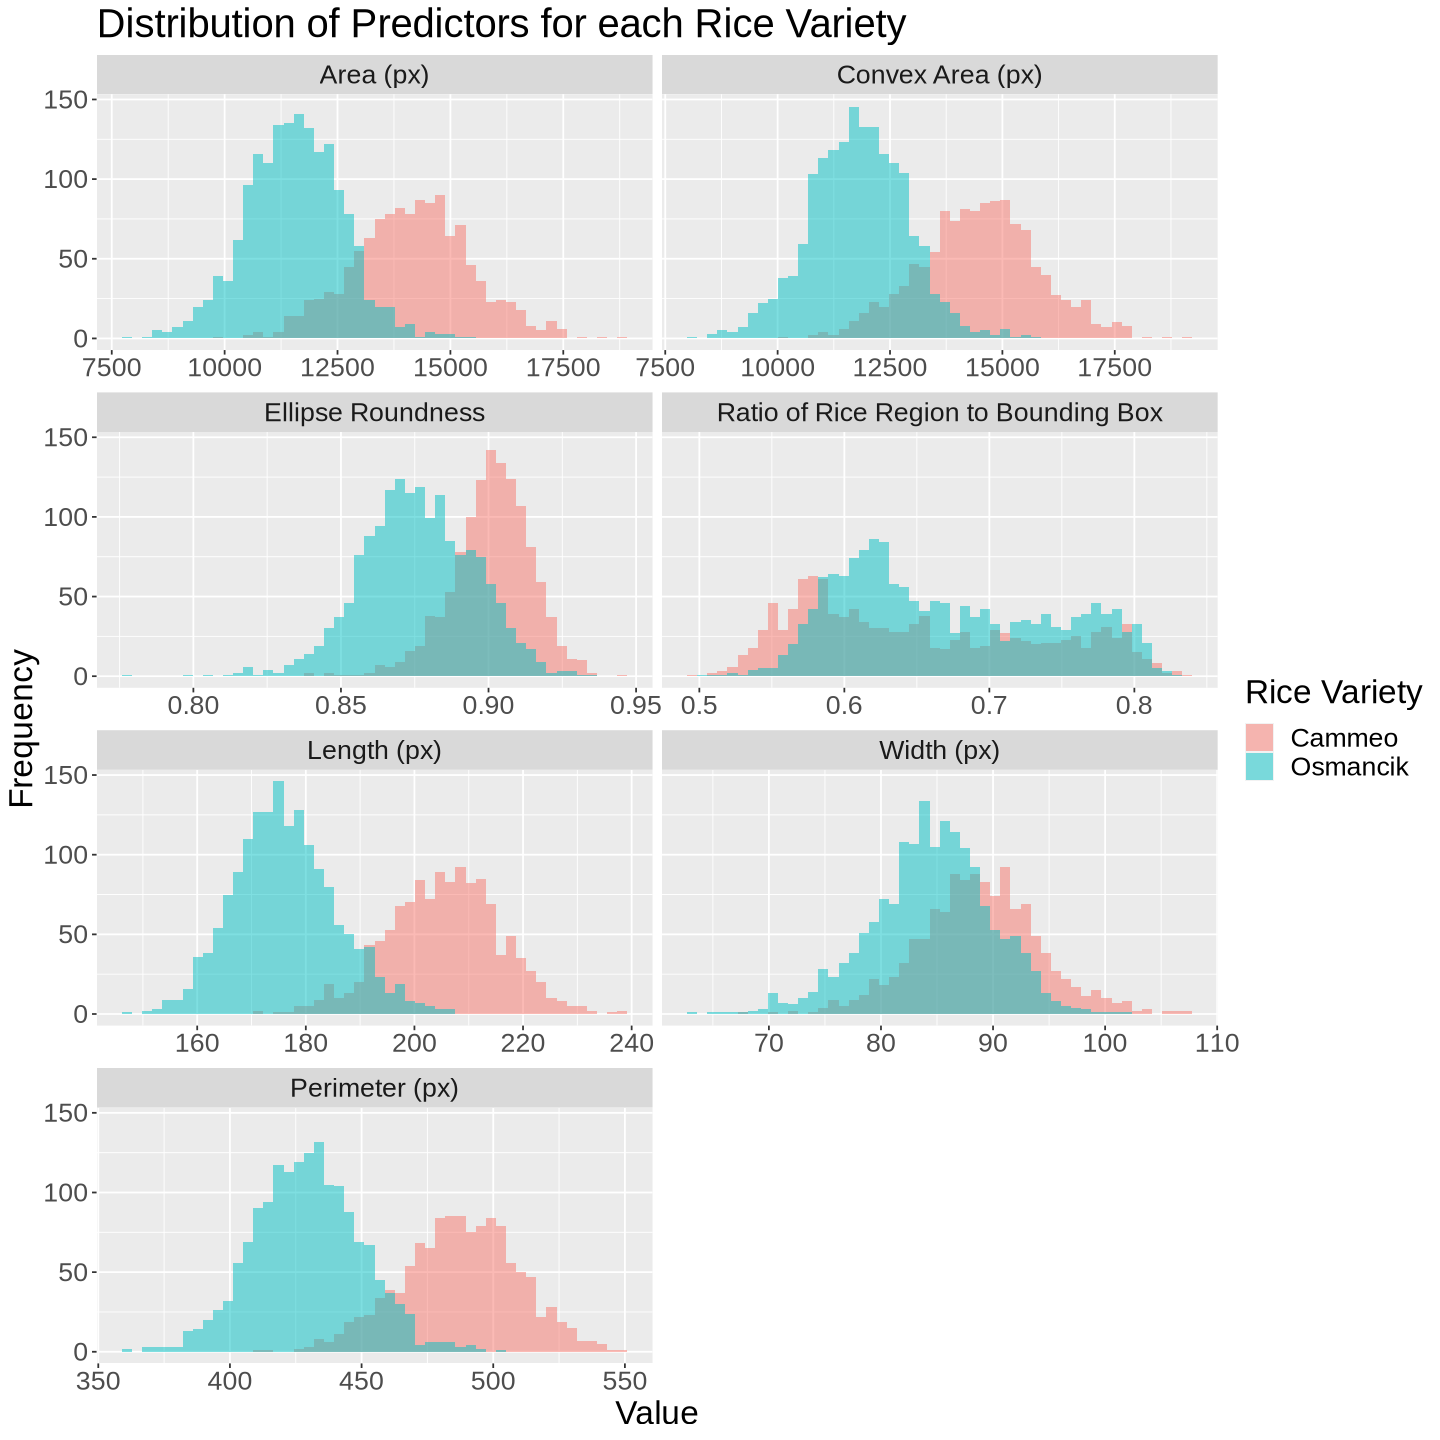

In [29]:
#Pivot long rice training set and create histograms for all predictors
rice_train_long <- rice_train |>
  pivot_longer(cols = area:extent, names_to = "predictor", values_to = "value")
rice_train_long

rice_labels <- c(
  area = "Area (px)",
  perimeter = "Perimeter (px)",
  major_axis_length = "Length (px)",
  minor_axis_length = "Width (px)",
  eccentricity = "Ellipse Roundness",
  convex_area = "Convex Area (px)",
  extent = "Ratio of Rice Region to Bounding Box")

rice_hist <- rice_train_long |>
  ggplot(aes(x = value, fill = class)) +
  geom_histogram(alpha = 0.5, position = "identity", bins = 50) +
  facet_wrap(~predictor, scales = "free_x", labeller = labeller(predictor = rice_labels), ncol = 2) +
  labs(title = "Distribution of Predictors for each Rice Variety",
       x = "Value", 
       y = "Frequency", 
       fill = "Rice Variety") +
  theme(text = element_text(size = 20))
rice_hist